### Starbucks Capstone Challenge
# Model Training

This notebook aims to train the models proposed to classify offers as appropriate or not.

## Define functions to train the classifiers

### Import the necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics as metrics
import torch
import torch.nn as nn
import torch.optim as optim

from models import LinearNN, RecurrentNN

### Load the datasets

In [2]:
!unzip -o dataloaders.zip
train_dataloader, valid_dataloader, test_dataloader = \
    torch.load('dataloaders.pt')

Archive:  dataloaders.zip
  inflating: dataloaders.pt          


### Define validation and training loops

In [17]:
def validate(model, dataloader=valid_dataloader):
    with torch.no_grad():
        model.eval()
        valid_loss = 0
        y_true = []
        y_pred = []
        for features, targets in dataloader:
            prediction = model(features)
            
            prediction = prediction.view(-1,2)
            targets = targets.view(-1)
            valid_loss += criterion(prediction, targets)

            prediction = torch.softmax(prediction, dim=1)
            _, prediction = prediction.topk(1, dim=1)
            prediction = prediction.squeeze()

            y_pred.extend(prediction.view(-1))
            y_true.extend(targets.view(-1))

        # normalize the loss
        valid_loss /= len(dataloader)
        valid_loss = valid_loss.item()

        # Calculate the metrics
        accuracy = metrics.accuracy_score(y_true, y_pred)
        c_matrix = metrics.confusion_matrix(y_true, y_pred)
        precision = metrics.precision_score(y_true, y_pred)
        recall = metrics.recall_score(y_true, y_pred)

        model.train()

        return valid_loss, accuracy, precision, \
               recall, c_matrix

In [4]:
def train(model, model_name='classifier',
          dataloader=train_dataloader, epochs=5000):
    train_loss = []
    valid_loss = []
    min_valid_loss = np.inf
    ## Perform N epochs of training
    for epoch in range(1, epochs+1):
        epoch_loss = 0
        for batch, (features, targets) in enumerate(dataloader):
            ## Train the network
            optimizer.zero_grad()
            prediction = model(features)
            prediction = prediction.view(-1,2)
            targets = targets.view(-1)
            loss = criterion(prediction, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Normalize the training loss
        epoch_loss /= len(dataloader)
        train_loss.append(epoch_loss)
        
        # LR scheduler step
        lr_scheduler.step(train_loss[-1])

        # Validate
        metrics = validate(model)
        valid_loss.append(metrics[0])
        print('Epoch {:4d}\ttrain loss: {:7.4f}\tvalid loss: {:7.4f}' \
              .format(epoch, train_loss[-1], valid_loss[-1]))

        # Save the model if valid_loss has decreased
        if valid_loss[-1] < min_valid_loss:
            min_valid_loss = valid_loss[-1]
            torch.save(model.state_dict(), model_name+'.pt')

    return train_loss, valid_loss

## Linear Classifier
This phase trains a feed-forward neural network to classify offer sending as appropriate or not.  
Being a traditional classification approach, this model will be the benchmark model to compare other classification methods.

In [5]:
linear_classifier = LinearNN(
    input_size=16, output_size=2, hidden_layers=[128,128,128])
criterion = nn.CrossEntropyLoss(
    torch.tensor([(42200. / 34072.), 1.]))
optimizer = optim.Adam(
    linear_classifier.parameters(), lr=0.0001, weight_decay=0.0001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.2, patience=20, verbose=True)

In [6]:
linear_loss = train(linear_classifier,
                    model_name='linear_classifier',
                    epochs=20)

Epoch    1	train loss:  0.6339	valid loss:  0.6037
Epoch    2	train loss:  0.5999	valid loss:  0.5924
Epoch    3	train loss:  0.5942	valid loss:  0.5876
Epoch    4	train loss:  0.5896	valid loss:  0.5848
Epoch    5	train loss:  0.5878	valid loss:  0.5832
Epoch    6	train loss:  0.5858	valid loss:  0.5830
Epoch    7	train loss:  0.5845	valid loss:  0.5818
Epoch    8	train loss:  0.5841	valid loss:  0.5809
Epoch    9	train loss:  0.5828	valid loss:  0.5805
Epoch   10	train loss:  0.5822	valid loss:  0.5795
Epoch   11	train loss:  0.5819	valid loss:  0.5792
Epoch   12	train loss:  0.5814	valid loss:  0.5790
Epoch   13	train loss:  0.5805	valid loss:  0.5784
Epoch   14	train loss:  0.5800	valid loss:  0.5787
Epoch   15	train loss:  0.5798	valid loss:  0.5786
Epoch   16	train loss:  0.5789	valid loss:  0.5781
Epoch   17	train loss:  0.5791	valid loss:  0.5777
Epoch   18	train loss:  0.5790	valid loss:  0.5776
Epoch   19	train loss:  0.5780	valid loss:  0.5773
Epoch   20	train loss:  0.5775	

## Recurrent Classifier
This phase trains a recurrent neural network to classify offer sending as appropriate or not.  
This project proposes this model as the most suitable classification approach, considering the fact that the data is sequential.

In [7]:
recurrent_classifier = RecurrentNN(
    input_size=16, output_size=2, hidden_size=128, hidden_layers=2)
criterion = nn.CrossEntropyLoss(
    torch.tensor([(42200. / 34072.), 1.]))
optimizer = optim.Adam(
    recurrent_classifier.parameters(), lr=0.0001, weight_decay=0.0001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.2, patience=20, verbose=True)

In [8]:
recurrent_loss = train(recurrent_classifier,
                       model_name='recurrent_classifier',
                       epochs=20)

Epoch    1	train loss:  0.6623	valid loss:  0.6510
Epoch    2	train loss:  0.6406	valid loss:  0.6336
Epoch    3	train loss:  0.6168	valid loss:  0.6078
Epoch    4	train loss:  0.6019	valid loss:  0.6001
Epoch    5	train loss:  0.5966	valid loss:  0.5976
Epoch    6	train loss:  0.5940	valid loss:  0.5941
Epoch    7	train loss:  0.5920	valid loss:  0.5930
Epoch    8	train loss:  0.5907	valid loss:  0.5910
Epoch    9	train loss:  0.5894	valid loss:  0.5909
Epoch   10	train loss:  0.5882	valid loss:  0.5892
Epoch   11	train loss:  0.5880	valid loss:  0.5881
Epoch   12	train loss:  0.5872	valid loss:  0.5882
Epoch   13	train loss:  0.5863	valid loss:  0.5870
Epoch   14	train loss:  0.5860	valid loss:  0.5885
Epoch   15	train loss:  0.5856	valid loss:  0.5862
Epoch   16	train loss:  0.5852	valid loss:  0.5862
Epoch   17	train loss:  0.5850	valid loss:  0.5865
Epoch   18	train loss:  0.5848	valid loss:  0.5858
Epoch   19	train loss:  0.5839	valid loss:  0.5845
Epoch   20	train loss:  0.5834	

## Results

### Training phase

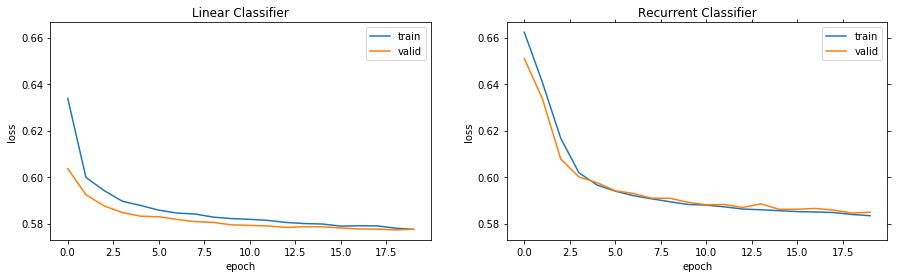

In [9]:
fig, (ax0, ax1) = plt.subplots(
    figsize=(15,4), nrows=1, ncols=2, sharey=True)

ax0.plot(linear_loss[0], label='train')
ax0.plot(linear_loss[1], label='valid')
ax0.set_title('Linear Classifier')
ax0.set_ylabel('loss')
ax0.set_xlabel('epoch')
ax0.legend()

ax1.plot(recurrent_loss[0], label='train')
ax1.plot(recurrent_loss[1], label='valid')
ax1.set_title('Recurrent Classifier')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend()
ax1.tick_params(reset=True)

plt.show()

### Testing the trained models

In [10]:
## Load the saved models

# Linear
linear_classifier.load_state_dict(
    torch.load('linear_classifier.pt'))

# Recurrent
recurrent_classifier.load_state_dict(
    torch.load('recurrent_classifier.pt'))

print('Models loaded successfully')

Models loaded successfully


In [19]:
## Test models

l_loss, l_acc, l_prec, l_rec, l_cmatrix = \
    validate(linear_classifier, test_dataloader)

r_loss, r_acc, r_prec, r_rec, r_cmatrix = \
    validate(recurrent_classifier, test_dataloader)

### Plot the test results

In [13]:
def build_cmatrix(c_matrix, ax):
    ax.matshow(c_matrix, cmap='YlGn')
    ax.set_xlabel('Confusion Matrix')
    ax.text(0, 0, f'TN\n{c_matrix[0,0]}',
            ha="center", va="center", color="w")
    ax.text(0, 1, f'FP\n{c_matrix[0,1]}',
            ha="center", va="center", color="k")
    ax.text(1, 0, f'FN\n{c_matrix[1,0]}',
            ha="center", va="center", color="k")
    ax.text(1, 1, f'TP\n{c_matrix[1,1]}',
            ha="center", va="center", color="k")

,Linear Classifier,Recurrent Classifier
accuracy (%),67.74%,66.80%
precision,0.6785,0.6728
recall,0.537,0.5094
loss,0.5695,0.5764


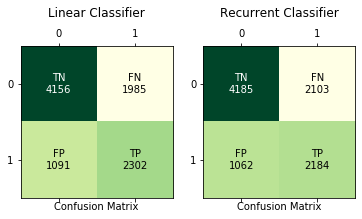

In [21]:
# Build the confusion matrix
fig, axs = plt.subplots(nrows=1, ncols=2)

build_cmatrix(l_cmatrix, axs[0])
axs[0].set_title('Linear Classifier\n')

build_cmatrix(r_cmatrix, axs[1])
axs[1].set_title('Recurrent Classifier\n')

# Table of results
result_df = pd.DataFrame(
    [[f'{l_acc*100:.2f}%', l_prec, l_rec, l_loss],
     [f'{r_acc*100:.2f}%', r_prec, r_rec, r_loss]],
    columns=['accuracy (%)', 'precision', 'recall', 'loss'],
    index=['Linear Classifier',
         'Recurrent Classifier']).T

# Display results
pd.set_option('display.precision', 4)
display(result_df)
plt.show()